In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("imported")
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
# import cv2

from __future__ import division, print_function, absolute_import
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure
from skimage.io import imread, imsave
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

imported
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4870396987425234210
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 209715200
locality {
  bus_id: 1
}
incarnation: 13879158289133794523
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0"
]


# Modeling Data Setup

### Load Data from File

In [3]:
def one_hot_encode(L, class_labels):
    """
    2D array (image) of segmentation labels -> .npy
    # One Hot Encode the label 2d array -> .npy files with dim (h, w, len(class_labels))
    # num classes will be 8? but currently dynamically allocated based on num colors in all scans.
    """
    h, w = L.shape  # Should be 482, 395 (unless resized)
    try:
        encoded = np.array([list(map(class_labels.index, L.flatten()))])

        L = encoded.reshape(h, w)

        Lhot = np.zeros((L.shape[0], L.shape[1], len(class_labels)))
        for i in range(L.shape[0]):
            for j in range(L.shape[1]):
                Lhot[i,j,L[i,j]] = 1
        return Lhot  # Should be shape (482, 395, 9)
    except Exception as e:
            print(e)

def uncode_one_hot(npy_file):
    """
    .npy file -> JPEG
    """
    pass

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def load_sparse_csr(filename):
    # Sparse matrix reading function to read our raw .npz files
    assert filename.endswith('.npz')
    loader = np.load(filename)  # filename must end with .npz
    return scipy.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

def get_raw_pixel_classes():
    #import nibabel as nib
    base_data_dir = "/home/jessica/Documents/hart-seg-ml/allrawnifti"
    example_segmentation = os.path.join(base_data_dir, 'trial8_30_fs_seg_ak5_lh4_TRANS.nii')
    scan_voxel = nib.load(example_segmentation)
    struct_arr = scan_voxel.get_data()
    n, h, w = struct_arr.shape
    class_labels = list(np.unique(struct_arr))
    
def check_one_hot(encoded_img):
    print(encoded_img.shape)
    return np.all(np.sum(encoded_img, axis=2) == 1.)

def batch_img_resize(images, h = 256, w = 256):
    images_resized = np.zeros([0, newHeight, newWidth], dtype=np.uint8)
    for image in range(images.shape[0]):
        temp = imresize(images[image], [h, w], 'nearest')
        images_resized = np.append(images_resized, np.expand_dims(temp, axis=0), axis=0)
    return images_resized

In [6]:
raw_pixel_classes =[0, 7, 8, 9, 45, 51, 52, 53, 68]  # Expected raw grayscale values for each pixel
#directory = "/Users/nozik/Documents/HARTresearch/allpreprocessed"
directory = "/home/jessica/Documents/hart-seg-ml/trial8_30_fs"
filenames = []  # Stores all filenames
raw_images = []  # Stores X (Raw cross section images as 2D np.ndarray)
segmentations = []  # Stores Y (Labeled/Segmented image as one-hot-encoded NumClasses-D np.ndarray)
h, w = 512, 512

for folder in os.listdir(directory):
    class_labels = set()
    if not folder.startswith('.'):
        path = os.path.join(directory, folder)
        print(path)
        files = sorted([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and not f.startswith('.')])
        
        # Class label sanity check
#         for f in files:
#             if 'label' in f:
#                 img = imread(os.path.join(path, f), flatten=True)
#                 class_labels = class_labels.union(np.unique(img))
#         if not class_labels.issubset(raw_pixel_classes):
#             print("Class labels found in labeled images do not match the expected classes for scan {}".format(folder))
#             print("Expected {}".format(raw_pixel_classes))
#             print("Received {}".format(sorted(class_labels)))
#             break
        
        # Sanity image read and show some images in pairs (play with the range inputs)
#         for f in range(0, len(files), 2):
#             label_name = files[f]
#             raw_name = files[f+1]
#             label_img = imread(os.path.join(path, label_name), flatten=True)
#             raw_img = load_sparse_csr(os.path.join(path, raw_name)).toarray()  # Load sparse csr mat img -> to 2D numpy array
#             show_images([label_img, raw_img], titles=[label_name, raw_name])
        
        # Set up Datasets (X, Y) pairs of data ->
        # files are sorted by the name: either '#_label' or '#_raw'
        for f in files:
            print(f)
            if 'label' in f:
                img = imread(os.path.join(path, f), flatten=True)
            else:
                img = load_sparse_csr(os.path.join(path, f)).toarray()            
            
#             imresize(seg[:,:,1],(h,w), interp='nearest')/255.0
            npad = ((15, 15), (58, 59))  # Pads to size 512, 512
            img = np.pad(img, pad_width=npad, mode='constant', constant_values=0)
            if 'raw' in f:
                raw_images.append(img)
            elif 'label' in f:
                encoded_img = one_hot_encode(img, raw_pixel_classes)
                segmentations.append(encoded_img)
            filenames.append(os.path.join(folder, f))
            
print(np.array(raw_images).shape)
print(np.array(segmentations).shape)

# print(filenames)

            
# images = np.array(images)
# segmentations = np.round(np.array(segmentations)).astype('uint8')


# study_num = int(2)
# train_lst = np.load('data/splits/train_lst_' + str(study_num) + '.npy')
# val_lst = np.load('data/splits/val_lst_' + str(study_num) + '.npy')

/home/jessica/Documents/hart-seg-ml/trial8_30_fs/trial8_30_fs
0_label.png
0_raw.npz
100_label.png
100_raw.npz
101_label.png
101_raw.npz
102_label.png
102_raw.npz
103_label.png
103_raw.npz
104_label.png
104_raw.npz
105_label.png
105_raw.npz
106_label.png
106_raw.npz
107_label.png
107_raw.npz
108_label.png
108_raw.npz
109_label.png
109_raw.npz
10_label.png
10_raw.npz
110_label.png
110_raw.npz
111_label.png
111_raw.npz
112_label.png
112_raw.npz
113_label.png
113_raw.npz
114_label.png
114_raw.npz
115_label.png
115_raw.npz
116_label.png
116_raw.npz
117_label.png
117_raw.npz
118_label.png
118_raw.npz
119_label.png
119_raw.npz
11_label.png
11_raw.npz
120_label.png
120_raw.npz
121_label.png
121_raw.npz
122_label.png
122_raw.npz
123_label.png
123_raw.npz
124_label.png
124_raw.npz
125_label.png
125_raw.npz
126_label.png
126_raw.npz
127_label.png
127_raw.npz
128_label.png
128_raw.npz
129_label.png
129_raw.npz
12_label.png
12_raw.npz
130_label.png
130_raw.npz
131_label.png
131_raw.npz
132_label.pn

### Split into Training, Cross Validation and Test sets

In [139]:
"""
TODO: Same Scan cannot be used across Train, Validation and Test sets
TODO: Different weight conditions and angles may be used to segment other raw_scans
TODO: Bounding Box, image resizing, padding edges
"""
# raw_images holds our X data
# segmentations holds out Y data
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

percent_train, percent_val, percent_test = 70, 0, 30
num_train = np.round(len(raw_images) * percent_train/100).astype(np.int)
num_val = np.round(num_train + len(raw_images) * percent_val/100).astype(np.int)
num_test = np.round(num_val + len(raw_images) * percent_test/100).astype(np.int)

print("num_train: ", num_train, "num_val: ", num_val, "num_test: ", num_test)

assert len(raw_images) == len(segmentations)
rand_indices = list(np.random.choice(len(raw_images), len(raw_images), replace=False))

for i in rand_indices[:num_train]:
    x_train.append(raw_images[i])
    y_train.append(segmentations[i])
for j in rand_indices[num_train:num_val]:
    x_val.append(raw_images[j])
    y_val.append(segmentations[j])
for k in rand_indices[num_val:num_test]:
    x_test.append(raw_images[k])
    y_test.append(segmentations[k])

        
x_train = np.array(x_train).reshape((len(x_train), h, w, 1))
x_test = np.array(x_test).reshape((len(x_test), h, w, 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Fix data padding to create square 482 by 482 matrix
# npad = ((0, 0), (15, 15), (58, 59), (0, 0))
# x_train = np.pad(x_train, pad_width=npad, mode='constant', constant_values=0)
# x_test = np.pad(x_test, pad_width=npad, mode='constant', constant_values=0)
# y_train = np.pad(y_train, pad_width=npad, mode='constant', constant_values=0)
# y_test = np.pad(y_test, pad_width=npad, mode='constant', constant_values=0)

# print()
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)


#     image = imresize(imread(directory + folder + '/' + folder + '.jpg', flatten = True),(h, w))
#     images.append(image)
#     filenames.append(folder)
#     seg = np.load(directory+folder+'/seg.npy')
#     temp = np.zeros((h,w,1))
#     temp[:,:,1] = imresize(seg[:,:,1],(h,w), interp='nearest')/255.0
#     segmentations.append(temp)

num_train:  697 num_val:  697 num_test:  996
(697, 512, 512, 1)
(299, 512, 512, 1)
(697, 512, 512, 9)
(299, 512, 512, 9)


# U-Net Model

In [8]:

class Unet(object):        
    def __init__(self, mean, weight_decay, learning_rate, label_dim = 8, dropout = 0.9):
        self.x_train = tf.placeholder(tf.float32, [None, h, w, 1])
        self.y_train = tf.placeholder(tf.float32, [None, h, w, 9])
        self.x_test = tf.placeholder(tf.float32, [None, h, w, 1])
        self.y_test = tf.placeholder(tf.float32, [None, h, w, 9])
        
        self.label_dim = label_dim
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.dropout = dropout

        self.output = self.unet(self.x_train, mean, keep_prob=self.dropout)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.output, labels = self.y_train))
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        self.pred = self.unet(self.x_test, mean, reuse = True, keep_prob = 1.0)
        self.loss_summary = tf.summary.scalar('loss', self.loss)
    
    # Gradient Descent on mini-batch
    def fit_batch(self, sess, x_train, y_train):
        _, loss, loss_summary = sess.run((self.opt, self.loss, self.loss_summary), feed_dict={self.x_train: x_train, self.y_train: y_train})
        return loss, loss_summary
    
    def predict(self, sess, x):
        prediction = sess.run((self.pred), feed_dict={self.x_test: x})
        return prediction

    def unet(self, input, mean, keep_prob = 0.9, reuse = None):
        with tf.variable_scope('vgg', reuse=reuse):
            input = input - mean  # Demean
            
            pool_ = lambda x: nn.max_pool(x, 2, 2)
            conv_ = lambda x, output_depth, name, padding = 'SAME', relu = True, filter_size = 3: nn.conv(x, filter_size, output_depth, 1, self.weight_decay, 
                                                                                                           name=name, padding=padding, relu=relu)
            deconv_ = lambda x, output_depth, name: nn.deconv(x, 2, output_depth, 2, self.weight_decay, name=name)
            
            conv_1_1 = conv_(input, 64, 'conv1_1')
            conv_1_2 = conv_(conv_1_1, 64, 'conv1_2')

            pool_1 = pool_(conv_1_2)

            conv_2_1 = conv_(pool_1, 128, 'conv2_1')
            conv_2_2 = conv_(conv_2_1, 128, 'conv2_2')

            pool_2 = pool_(conv_2_2)

            conv_3_1 = conv_(pool_2, 256, 'conv3_1')
            conv_3_2 = conv_(conv_3_1, 256, 'conv3_2')

            pool_3 = pool_(conv_3_2)

            conv_4_1 = conv_(pool_3, 512, 'conv4_1')
            conv_4_2 = conv_(conv_4_1, 512, 'conv4_2')

            pool_4 = pool_(conv_4_2)

            conv_5_1 = conv_(pool_4, 1024, 'conv5_1')
            conv_5_2 = conv_(conv_5_1, 1024, 'conv5_2')
            
            pool_5 = pool_(conv_5_2)
            
            conv_6_1 = tf.nn.dropout(conv_(pool_5, 2048, 'conv6_1'), keep_prob)
            conv_6_2 = tf.nn.dropout(conv_(conv_6_1, 2048, 'conv6_2'), keep_prob)
            
            up_7 = tf.concat([deconv_(conv_6_2, 1024, 'up7'), conv_5_2], 3)  # Error here rn
            
            conv_7_1 = conv_(up_7, 1024, 'conv7_1')
            conv_7_2 = conv_(conv_7_1, 1024, 'conv7_2')

            up_8 = tf.concat([deconv_(conv_7_2, 512, 'up8'), conv_4_2], 3)
            
            conv_8_1 = conv_(up_8, 512, 'conv8_1')
            conv_8_2 = conv_(conv_8_1, 512, 'conv8_2')

            up_9 = tf.concat([deconv_(conv_8_2, 256, 'up9'), conv_3_2], 3)
            
            conv_9_1 = conv_(up_9, 256, 'conv9_1')
            conv_9_2 = conv_(conv_9_1, 256, 'conv9_2')

            up_10 = tf.concat([deconv_(conv_9_2, 128, 'up10'), conv_2_2], 3)
            
            conv_10_1 = conv_(up_10, 128, 'conv10_1')
            conv_10_2 = conv_(conv_10_1, 128, 'conv10_2')

            up_11 = tf.concat([deconv_(conv_10_2, 64, 'up11'), conv_1_2], 3)
            
            conv_11_1 = conv_(up_11, 64, 'conv11_1')
            conv_11_2 = conv_(conv_11_1, 64, 'conv11_2')
            
            conv_12 = conv_(conv_11_2, 9, 'conv12_2', filter_size = 1, relu = False)
            return conv_12

In [9]:
# Hyperparameters
mean = 0
weight_decay = 1e-6
learning_rate = 1e-4
label_dim = 8
maxout = False

# Create TF graph and initialize variables
tf.reset_default_graph()
sess = tf.Session()
model = Unet(mean, weight_decay, learning_rate, label_dim , dropout = 0.5)
sess.run(tf.global_variables_initializer())

/home/jessica/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [58]:
# Restore old model
# saver = tf.train.Saver()
# saver.restore(sess, '/media/deoraid03/jeff/models/a4c_experiments/deep_256_2')

In [14]:
# Train Model
nn.train(sess, model, x_train, y_train, x_test, y_test, epochs = 1500, batch_size = 1)

Epoch 0 | Iter 696 | Loss: 0.0052 | Acc: [0.449 0.386 0.373 0.316 0.    0.633 0.308 0.496] | Time 2e+02     
Epoch 1 | Iter 696 | Loss: 0.006 | Acc: [0.45  0.393 0.375 0.317 0.    0.632 0.308 0.503] | Time 2e+02     
Epoch 2 | Iter 696 | Loss: 0.006 | Acc: [0.447 0.393 0.372 0.316 0.    0.628 0.308 0.497] | Time 2e+02     
Epoch 3 | Iter 696 | Loss: 0.0049 | Acc: [0.448 0.394 0.377 0.312 0.    0.628 0.308 0.496] | Time 2e+02     
Epoch 4 | Iter 696 | Loss: 0.0055 | Acc: [0.452 0.394 0.377 0.313 0.    0.633 0.31  0.5  ] | Time 2e+02     
Epoch 5 | Iter 696 | Loss: 0.0057 | Acc: [0.449 0.39  0.377 0.317 0.    0.63  0.309 0.508] | Time 2e+02     
Epoch 6 | Iter 696 | Loss: 0.005 | Acc: [0.451 0.393 0.378 0.319 0.    0.631 0.31  0.491] | Time 2e+02     
Epoch 7 | Iter 696 | Loss: 0.0053 | Acc: [0.45  0.391 0.378 0.319 0.    0.636 0.311 0.508] | Time 2e+02     
Epoch 8 | Iter 696 | Loss: 0.0042 | Acc: [0.452 0.393 0.38  0.322 0.    0.638 0.314 0.512] | Time 2e+02     
Epoch 9 | Iter 696 | L

KeyboardInterrupt: 

In [15]:
# IOU Accuracies for each label
nn.validate(sess, model, x_test, y_test)

[0.45767510773988007,
 0.40961342796952677,
 0.38978632868604635,
 0.3472888391430638,
 0.00042709446853944584,
 0.6453268071187512,
 0.32879205137810524,
 0.5306124158695751]

In [16]:
# Save model
saver = tf.train.Saver()
saver.save(sess, '/home/jessica/Documents/hart-seg-ml/models/secondrun')

'/home/jessica/Documents/hart-seg-ml/models/secondrun'

In [22]:
print(x_test.shape)
print(y_test.shape)

(299, 512, 512, 1)
(299, 512, 512, 9)


In [146]:
print(x_test[0:1].shape)
print(np.unique(x_test[0:1]).shape)
prediction = model.predict(sess, x_test[0:1])
print(prediction[0][233][255])

pred_classes = np.argmax(prediction[0], 2)
print(pred_classes.shape)

#np.nonzero(pred_classes)

(1, 512, 512, 1)
(11173,)
[ 36.086708  -10.721292  -19.514847  -17.278486   -4.452541  -30.116741
   5.0739784 -14.627988  -27.309132 ]
(512, 512)


In [159]:
raw_imgs_arr = np.array(raw_images)
raw_imgs_arr = np.expand_dims(raw_imgs_arr, axis=3)
print(raw_imgs_arr.shape)


(996, 512, 512, 1)


In [173]:
def predict_cross_sec(x, model, sess):
    prediction = model.predict(sess, x)
    pred_classes = np.argmax(prediction[0], axis=2)
    return pred_classes

    
def predict_whole_seg(X, model, sess):
    segmented = np.empty(X.shape[:3])
    num_sections = X.shape[0]
    for i in range(num_sections):
        pred = predict_cross_sec(X[i:i+1], model, sess)
        segmented[i] = pred
        print(i, end=', ')
    return segmented


def crop_cross_sec(cross_sec):
    '''
    512, 512 -> 482, 395
    npad = ((15, 15), (58, 59))  # Pads to size 512, 512
    img = np.pad(img, pad_width=npad, mode='constant', constant_values=0)
    '''
    return cross_sec
    
    


def convert_seg_to_nifti(seg):
    base_data_dir = "/home/jessica/Documents/hart-seg-ml/allrawnifti"
    original_vol = nib.load(os.path.join(base_data_dir, 'trial8_30_fs_volume_TRANS.nii'))
    new_header = original_vol.header.copy()
    new_nifti = nib.nifti1.Nifti1Image(seg, None, header=new_header)
    nib.save(new_nifti, '/home/jessica/Documents/hart-seg-ml/predictedsegs/firsttest/predicted_segmentation.nii')


In [174]:
all_segs = predict_whole_seg(raw_imgs_arr, model, sess)


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [176]:
print(all_segs.shape)


(996, 512, 512)


In [175]:
convert_seg_to_nifti(all_segs)

[]

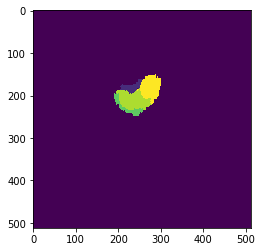

In [170]:
#flat_prediction = prediction.flatten()
plt.imshow(all_segs[520])
plt.plot()
